Sheet 1.2: RSA with politeness
==============================

**Author:** Michael Franke



This is a (numpy-based) Python implementation of an RSA model with a speaker who has two weighted objectives:
(i) being informative about the true world state and
(ii) being polite.
The latter is taken to mean that the speaker wants to increase the listener&rsquo;s degrees of beliefs in particular world states even if they are not true.

The same model is also covered in [chapter 9 of problang.org](http://www.problang.org/chapters/09-politeness.html) (Scontras et. al 2018).
The model covered here is essentially that of [Yoon et al. (2016)](http://langcog.stanford.edu/papers_new/yoon-2016-cogsci.pdf).



Student: Jia Sheng (5371477)

## Packages & helper functions



We use the same kinds of packages as before.



In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Also, we use the same helper functions as in Sheet 1.1 for computing soft-max and normalization of array dimensions.



In [2]:
##################################################
## helper functions
##################################################

def softmax(x, axis=1):
    """
    Softmax function in numpy
    Parameters
    ----------
    x: array
        An array with any dimensionality
    axis: int
        The axis along which to apply the softmax
    Returns
    -------
    array
        Same shape as x
    """
    e_x = np.exp(x - np.max(x, axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)


def normalize(arr, axis=1):
    """
    Normalize arr along axis
    """
    return arr / arr.sum(axis, keepdims=True)

## Running example



As a running example, we consider a context in which the speaker reports on their impression of the quality of the listener&rsquo;s self-baked cookies.

We assume that there are five world states, represented as increasing integers.
These numbers represent the true quality of the cookies (as perceived by the speaker).

We also assume that there are five expressions the speaker might want to use to report their quality assessment.
The semantic meaning we use for these expressions is a &ldquo;soft-semantics&rdquo; (truth-values are not confined to 0 and 1), which are derived from an experiment designed to elicit participants intuitions about the relevant semantic meanings ([Yoon et al. 2016](http://langcog.stanford.edu/papers_new/yoon-2016-cogsci.pdf)).



In [3]:
##################################################
## defining the context
##################################################

states     = [1,2,3,4,5]
utterances = ["terrible","bad","okay","good","amazing"]

semantic_meaning = np.array(
    [[.95 ,.85 ,.02 ,.02,.02],    # terrible
     [.85 ,.95 ,.02 ,.02,.02],    # bad
     [.02 ,.25 ,.95 ,.65,.35],    # okay
     [.02 ,.05 ,.55 ,.95,.93],    # good
     [.02 ,.02 ,.02 ,.65,.95]]    # amazing
)

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 1.2.1: Check experiment and your intuitions</span></strong>
>
> 1. Consult the original paper ([Yoon et al. 2016](http://langcog.stanford.edu/papers_new/yoon-2016-cogsci.pdf)) to find the description of the experiment that was used to get these semantic values. Describe this experiment in at most three simple sentences: what was the question participants had to answer and how were answers recorded?
> 2. Comment on whether you find the obtained values intuitive as values of the semantic meaning of these expression.
> 3. Do you think that the experiment was well-designed for the task of eliciting information about semantic meaning of expressions?



###Answers to exercise 1.2.1: 
1. The participants were given a context of someone's performance and another person's evaluation on a scale, and were asked to if they accept a evaluation word given that state. The answers were recorded as proportion of acceptances of that word in those 5 different states.
2. I found the obtained values intuitive refering to those words' semantic meaning, although I wondered why the lowest percentage is 0.02 instead of 0, i.e. why are 2% of people accepting the five hearts rating as terrible.
3. I think the experiment was well-designed for that purpose. But I could also imagine that if the questions are asked in a yes-no state, some people might be influenced by preconceived notions to agree upon words that they normally might not think so suitable.

## The model and its parameters



The polite-language model is defined as follows:

\begin{align*}
P_{lit}(s \mid u) & \propto L(u,s) \\
P_{S}( u \mid s, {\color{3F9786}{\varphi}}) & = \mathrm{SoftMax}\left ( \alpha  U (s, u,  {\color{3F9786}{\varphi}}) \right) \\
U (s, u,  {\color{3F9786}{\varphi}}) & = {\color{3F9786}{\varphi}} \ \log P_{lit}(s \mid u) + (1-{\color{3F9786}{\varphi}}) \sum_{s'} P_{lit}(s' \mid u) \ V(s') \\
P_{L}( s, {\color{3F9786}{\varphi}} \mid u) & \propto P(s) \ P({\color{3F9786}{\varphi}}) \ P_{S_1}( u \mid s, {\color{3F9786}{\varphi}})
\end{align*}

The key novelty is a composite utility function for the speaker, which is defined as a weighted sum (with weight $\varphi$) over two components: epistemic and social utility.
We assume here that the value function $V(s)$ is a linear function of the star rating: $V(s) = v s$, where $v$ is a model parameter called &ldquo;social value&rdquo;.

In sum, this model has free parameters $\alpha$, $\varphi$ and $v$.



In [4]:
##################################################
## model parameters
##################################################

alpha        = 10
phi          = 0.99
social_value = 1.25

## Implementation and visualization



Let&rsquo;s look at the speaker and listener part separately.



### Polite speakers



   terrible   bad  okay  good  amazing  object
1      0.75  0.25  0.00  0.00     0.00       1
2      0.25  0.75  0.00  0.00     0.00       2
3      0.00  0.00  1.00  0.00     0.00       3
4      0.00  0.00  0.03  0.40     0.57       4
5      0.00  0.00  0.00  0.01     0.99       5


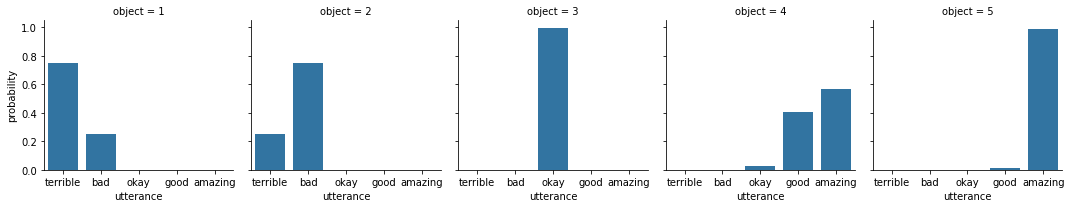

In [5]:
##################################################
## RSA speaker with politeness
##################################################

def RSA_polite_speaker(alpha, phi, social_value):
    """
    predictions of an RSA model with politeness (speaker part)
    (following: http://www.problang.org/chapters/09-politeness.html)
    Parameters
    ----------
    alpha: float
        Optimality parameter
    phi: float
        Relative weight of epistemic utility component
    social_value: float
        Social value factor (how much more "socially valuable" is one more star?)
    Returns
    -------
    array
        probability that speaker chooses utterance for each state
    """
    literal_listener   = normalize(semantic_meaning)
    epistemic_utility  = np.log(np.transpose(literal_listener))
    social_utility     = np.sum(literal_listener * np.array([states]) * social_value, axis=1)
    util_speaker       = phi * epistemic_utility + (1-phi) * social_utility
    pragmatic_speaker  = softmax(alpha * util_speaker)
    return(pragmatic_speaker)

RSA_speaker_predictions = RSA_polite_speaker(alpha, phi, social_value)

##################################################
## showing and plotting the results
##################################################

speaker  = pd.DataFrame(data    = RSA_speaker_predictions,
                        index   = states,
                        columns = utterances)
speaker['object'] = speaker.index

print(speaker.round(2))

speaker_long = speaker.melt(id_vars      = "object",
                            var_name     = "utterance",
                            value_name   = "probability",
                            ignore_index = False)
speaker_plot = sns.FacetGrid(speaker_long, col="object")
speaker_plot.map(sns.barplot, "utterance", "probability")
plt.show()

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 1.2.2: Explore the polite speaker model</span></strong>
>
> 0. For yourself, in order to understand the model, go through each line of the definition of the function \`RSA<sub>polite</sub><sub>speaker</sub>\` and make sure that you understand what is happening.
> 1. Change the call to the speaker to make it so that it only cares about making the listener feel good. What parameter value(s) did you choose?
> 2. Change the call to the speaker to make it so that it cares about both making the listener feel good *and* conveying information. What parameter value(s) did you choose?
> 3. If we set $\varphi=1$, and choose a very high $\alpha$, the speaker behavior is quite regular. Is this kind of behavior intuitive? Do you think it happens in real life?
> 4. Is there a parameter setting for this model, such that the speaker would at most choose one category higher when trying to be polite? For example, when they should informatively say &rsquo;okay&rsquo;, they would say &rsquo;good&rsquo;, but never &rsquo;amazing&rsquo;. Which parameters achieve this? Or, how could the model be changed to achieve this behavior?



In [6]:
# Exercise 1.2.2.1

# I choose to change phi value to 0 to give all weights to social utilities
phi = 0

# run the model and print the results
RSA_speaker_predictions = RSA_polite_speaker(alpha, phi, social_value)

speaker  = pd.DataFrame(data    = RSA_speaker_predictions,
                        index   = states,
                        columns = utterances)
speaker['object'] = speaker.index

print(speaker.round(2))

   terrible  bad  okay  good  amazing  object
1       0.0  0.0   0.0  0.01     0.99       1
2       0.0  0.0   0.0  0.01     0.99       2
3       0.0  0.0   0.0  0.01     0.99       3
4       0.0  0.0   0.0  0.01     0.99       4
5       0.0  0.0   0.0  0.01     0.99       5


In [15]:
# Exercise 1.2.2.2

# I choose to change phi value to 0.5 to give equal weights to epistemic and social utilities
# and lower social value factor to mitiate the influence of politeness
phi = 0.5
social_value = 1.1

# run the model and print the results
RSA_speaker_predictions = RSA_polite_speaker(alpha, phi, social_value)

speaker  = pd.DataFrame(data    = RSA_speaker_predictions,
                        index   = states,
                        columns = utterances)
speaker['object'] = speaker.index

print(speaker.round(2))

   terrible   bad  okay  good  amazing  object
1      0.62  0.37  0.00  0.00     0.00       1
2      0.00  0.00  0.99  0.00     0.00       2
3      0.00  0.00  0.48  0.52     0.00       3
4      0.00  0.00  0.00  0.01     0.99       4
5      0.00  0.00  0.00  0.00     1.00       5


In [16]:
# Exercise 1.2.2.3

# set φ=1, and choose a very high α
phi = 1
alpha = 20

# run the model and print the results
RSA_speaker_predictions = RSA_polite_speaker(alpha, phi, social_value)

speaker  = pd.DataFrame(data    = RSA_speaker_predictions,
                        index   = states,
                        columns = utterances)
speaker['object'] = speaker.index

print(speaker.round(2))

   terrible  bad  okay  good  amazing  object
1       0.9  0.1   0.0  0.00     0.00       1
2       0.1  0.9   0.0  0.00     0.00       2
3       0.0  0.0   1.0  0.00     0.00       3
4       0.0  0.0   0.0  0.35     0.64       4
5       0.0  0.0   0.0  0.00     1.00       5


###Answer to Exercise 1.2.2.3
the regular speaker behaviour is intuitive. Since if we adjust phi to 1, that means we do not consider social value factor at all anymore, so the speaker behaviour would not be influenced by politeness at all. Besides, the high alpha value, the more optimal the pragmatic speaker is. So as a result, the speaker behaviour is very predictable.

In [20]:
# Exercise 1.2.2.4

# this can be acheived by a lower phi value and socal value
phi = 0.5
social_value = 1.1

# run the model and print the results
RSA_speaker_predictions = RSA_polite_speaker(alpha, phi, social_value)

speaker  = pd.DataFrame(data    = RSA_speaker_predictions,
                        index   = states,
                        columns = utterances)
speaker['object'] = speaker.index

print(speaker.round(2))

   terrible   bad  okay  good  amazing  object
1      0.62  0.37  0.00  0.00     0.00       1
2      0.00  0.00  0.99  0.00     0.00       2
3      0.00  0.00  0.48  0.52     0.00       3
4      0.00  0.00  0.00  0.01     0.99       4
5      0.00  0.00  0.00  0.00     1.00       5


### Pragmatic listener reasoning about politeness



The pragmatic listener is more complicated for this model.
This is a form of *joint-inference* where more than one variable of interest is inferred.
Concretely, the pragmatic listener jointly infers the world state and the degree of honesty/politeness.
For ease of implementation, we discretize the set of possible values for $\varphi$.



listener posterior over states after hearing 'good':
 [0.00310198 0.0057047  0.39856637 0.58844097 0.00418597]
plotting listener posterior for utterance: good


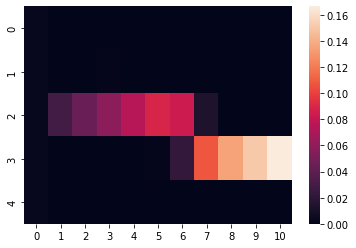

In [21]:
##################################################
## pragmatic listener infers politeness level
##################################################

# which phi-values to consider
phi_marks     = np.linspace(start=0, stop=1, num=11)
phi_prior_flt = np.array([1,1,1,1,1,1,1,1,1,1,1])   # flat
phi_prior_bsd = np.array([1,2,3,4,5,6,7,8,9,10,11]) # biased towards politeness

def RSA_polite_listener(alpha, phi_prior, social_value):
    """
    predictions of an RSA model with politeness (listener part)
    (following: http://www.problang.org/chapters/09-politeness.html)
    Parameters
    ----------
    alpha: float
        Optimality parameter
    phi_priors: float
        Prior over degree of politeness (phi-parameter)
    social_value: float
        Social value factor (how much more "socially valuable" is one more star?)
    Returns
    -------
    array
         for each message: listener posterior over state-phi pairs
    """
    phi_prior = phi_prior / np.sum(phi_prior) # make sure priors are normalized
    posterior = np.zeros((len(utterances), len(states),len(phi_marks)))
    for i in range(len(phi_marks)):
        pragmatic_speaker   = RSA_polite_speaker(alpha, phi_marks[i], social_value)
        posterior_given_phi = normalize(np.transpose(pragmatic_speaker), axis=1)
        posterior[:,:,i]    = posterior_given_phi * phi_prior[i]
    return(posterior)

RSA_listener_predictions = RSA_polite_listener(alpha, phi_prior_bsd, social_value)

print("listener posterior over states after hearing 'good':\n",
      np.sum(RSA_listener_predictions[3,:,:], axis=1))

iterables=[utterances, states, phi_marks]
index = pd.MultiIndex.from_product(iterables, names=['utterances','states','phi'])

listener = pd.DataFrame(RSA_listener_predictions.reshape(RSA_listener_predictions.size, 1),
                        index=index)
listener = listener.reset_index()

##################################################
## plotting the results
##################################################

def plot_listener(utterance_index):
    print("plotting listener posterior for utterance:", utterances[utterance_index])
    predictions = RSA_listener_predictions[utterance_index,:,:]
    sns.heatmap(predictions)
    plt.show()

plot_listener(3)

> <strong><span style=&ldquo;color:#D83D2B;&rdquo;>Exercise 1.2.3: Explore the pragmatic listener</span></strong>
>
> 0. For yourself, in order to understand the model, go through each line of the definition of the function \`RSA<sub>polite</sub><sub>listener</sub>\` and make sure that you understand what is happening.
> 1. What does the heatmap show? What&rsquo;s on the x-axis, what&rsquo;s on the y-axis, and what do the colors mean?
> 2. Add a function that takes an utterance index (0, &#x2026;, 4) and outputs three things: (i) a print out of the [marginal distribution](https://en.wikipedia.org/wiki/Marginal_distribution) over states, (ii) a print out of the marginal distribution over $\varphi$ values, and (iii) the heatmap visualizing the joint-distribution of both.
> 3. Compare the interpretation of the utterance &rsquo;amazing&rsquo; with that of the other utterances (for the parameter values used originally). Explain in what sense the distribution shown for &rsquo;amazing&rsquo; is a [multimodal distribution](https://en.wikipedia.org/wiki/Multimodal_distribution). Explain why the model makes this multi-modal prediction for &rsquo;amazing&rsquo;. Does it also predict multi-modality for &rsquo;good&rsquo;? What about &rsquo;terrible&rsquo;?



### Answer to Exercise 1.2.3.1:
The heatmap shows the listener's judgment of joint probabilities over states and speaker politeness after hearing 'good'. The x-axis is the degree that the utterance is biased by politeness, the y-axis is the five states of evaluation. The color scale shows how high the joint probabilities of the states and politeness degree based on listener's judgment.

utterance index:  4
Marginal distribution over states:
[0.06151203 0.03456936 0.00880433 0.41627639 0.47883789]
Marginal distribution over alpha values
[0.01515152 0.03030303 0.04545455 0.06060606 0.07575758 0.09090909
 0.10606061 0.12121212 0.13636364 0.15151515 0.16666667]
plotting listener posterior for utterance: amazing


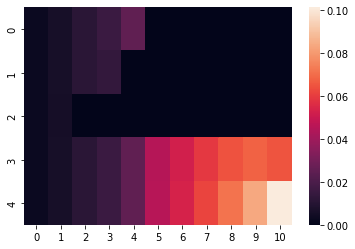

In [24]:
# Exercise 1.2.3.2

# define the function that takes an utterance index (0, ..., 4)
def print_marginals(utterance_index):
  RSA_listener_predict = RSA_polite_listener(alpha, phi_prior_bsd, social_value)

  print("utterance index: ", utterance_index)

  # print out the marginal distribution over states
  print("Marginal distribution over states:")
  print(np.sum(RSA_listener_predictions[utterance_index,:,:], axis=1))

  #print out the marginal distribution over alpha values
  print("Marginal distribution over alpha values")
  print(np.sum(RSA_listener_predictions[utterance_index,:,:], axis=0))

  #print the heatmap visualizing the joint-distribution of both
  plot_listener(utterance_index)


# test the function
print_marginals(4)

### Answer to Exericse 1.2.3.3
A multimodal distribution is a probability distribution with more than one mode. According to the joint probabilities of "amazing" printed out above, they have two peaks in the marginal distribution over states, namely one at state 1 and one at state 4. From the heatmap we can also see the two highlited areas that are separated from one another. Therefore, it can be qualified as a multimodal distribution.

The reason of this multimodality might be because that the modal calculates the joint probabilities. From the polite speaker model we can observe that when the politeness level is very high (phi value very low), it is more possible for state 0 to 1 to produce the utterance "amazing" than state 3. That is probably why there is a peak at state 1. And then, when the phi value is high (low politeness level), it is very possible for polite speaker to utter "amazing" when at the state 4 and 5, so there is again a peak at the joint probabilities that this modal predicts.

For "good", according to the data above, the model does not predict multi-modality. And for "terrible", as tested below, it also does not predict multi-modality. This is probabily because for these two utterances, there is no obvious split of states (continous trend) when uttered by the polite speaker model.

utterance index:  0
Marginal distribution over states:
[0.85437804 0.13652423 0.00303711 0.00303031 0.00303031]
Marginal distribution over alpha values
[0.01515152 0.03030303 0.04545455 0.06060606 0.07575758 0.09090909
 0.10606061 0.12121212 0.13636364 0.15151515 0.16666667]
plotting listener posterior for utterance: terrible


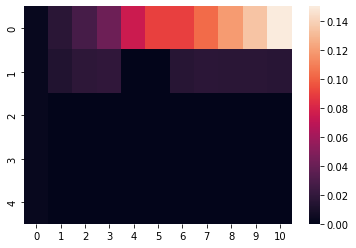

In [25]:
# test the utterance for "terrible"
print_marginals(0)

## References



Scontras, G., Tessler, M. H., & Franke, M. (2018). [Probabilistic language understanding: An introduction to the Rational Speech Act framework](http://www.problang.org).

Yoon, E. J., Tessler, M. H., Goodman, N. D., & Frank, M. C. (2016). [Talking with tact: polite language as a balance between kindness and informativity](http://langcog.stanford.edu/papers_new/yoon-2016-cogsci.pdf). In: *Proceedings of CogSci* 38.

